<a href="https://colab.research.google.com/github/anh1811/YOLO/blob/main/yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !git clone https://github.com/ultralytics/yolov5  # clone repo
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
from IPython.display import Image, clear_output  # to display images
import torchvision
import pickle as pkl
import numpy as np
import os
import cv2
from torchvision import transforms
clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # %mkdir data
# # %cd data
# !wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/data/coco.names

# # %mkdir cfg
# # %cd cfg
# !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

Setup complete. Using torch 1.9.0+cu102 (CPU)


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
%cd
%cd /content/drive/MyDrive/Data/yolov3

Mounted at /content/drive
/root
/content/drive/MyDrive/Data/yolov3


In [ ]:
def read_class(file):
    with open(file, 'r') as name:
        classes = name.read().split('\n')
    return classes

In [ ]:
# dictionary classes and colors
classes = read_class('data/coco.names')[:-1]
colors = pkl.load(open("pallete", "rb"))

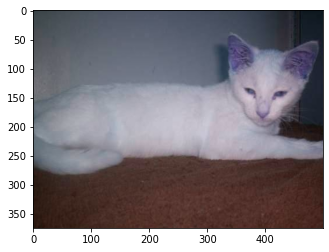

In [ ]:
# !unzip test.zip
list_im = list(os.listdir('test'))
img = cv2.imread(os.path.join('test', list_im[0]))
plt.imshow(img)

In [ ]:
class Testdataset(torch.utils.data.Dataset):
    #create a testdataset for detection
    # image and their size 
    
    def __init__(self, test_dir, transform):
        self.list_pimg = list(os.listdir(test_dir))[:100]
        self.list_im = [cv2.imread(os.path.join('test',img)) for img in self.list_pimg]
        self.transform = transform
        
    def __getitem__(self,index):
        img = self.list_im[index]
        size = img.shape[:2]
        
        sample = img, size
        if self.transform:
            img = self.transform(img)
        
        return img.type(torch.float),size
    
    def __len__(self):
        return len(self.list_im)

In [ ]:
class Padding(object):
    def __init__(self, inp_dim):
        assert isinstance(inp_dim, (int, tuple))
        self.inp_dim = inp_dim
        
    def __call__(self, img):
        w, h = img.shape[1], img.shape[0]
        scale = min(self.inp_dim/w, self.inp_dim/h)
        
        # one of this axis will have the same length as the inp_dim
        w_new = int(w * scale)
        h_new = int(h * scale)
        img = cv2.resize(img, (w_new, h_new))
        
        #create a image that is full 128
        image = np.full((self.inp_dim, self.inp_dim, 3), 128.)
        #paste the img into the middle
        image[(self.inp_dim - h_new)//2:(self.inp_dim - h_new)//2 + h_new, 
              (self.inp_dim - w_new)//2:(self.inp_dim - w_new)//2 + w_new,  :] = img
        return image

In [ ]:
basic_transform = transforms.Compose([Padding(inp_dim = 416), 
                                      transforms.ToTensor(),
                                     transforms.Normalize(mean = 0., std = 255.)])
dataset = Testdataset(test_dir = 'test', transform = basic_transform)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset, batch_size = 25)

In [ ]:
def parsefile(file):
    #read config file and return a list of dictionary 
    config = open(file, 'r')
    lines = config.read().split('\n')
    lines = [x for x in lines if len(x) != 0]
    lines = [x for x in lines if x[0] != '#']
    lines = [x.strip() for x in lines] 
    
    block = {}
    blocks = []

    for line in lines:
        if line[0] == '[':
            if len(block) != 0:
                blocks.append(block)
                block = {}
            block['type'] = line[1:-1].rstrip()
        else:
            key, value = line.split('=')
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)
    return blocks

In [ ]:
class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors

class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()

In [ ]:
def building_models(blocks):
    # building model from block 
    # parameters = blocks 
    
    #model info
    net_info = blocks[0]
    list_module = nn.ModuleList()
    input_size = 3
    output_filters = []
    for i, block in enumerate(blocks[1:]):
        module = nn.Sequential() #convol module can have a lot of layer
        
        #convolutional layer
        if block['type'] == 'convolutional':
            # is there batch_normalize 
            try:
                batch_normalize = int(block['batch_normalize'])
                bias = False
            except:
                batch_normalize = 0
                bias = True
            
            # arguments for conv2d
            output_size = int(block['filters'])
            kernel_size = int(block['size'])
            stride = int(block['stride'])
            pad = int(block['pad'])
            if pad:
                padding = (kernel_size - 1) // 2
            else:
                padding = 0
            conv = nn.Conv2d(input_size, output_size, kernel_size = kernel_size, stride = stride, padding = padding,
                            bias = bias)
            module.add_module('conv_{}'.format(i), conv)
            
            #perform batch_normalize
            if batch_normalize:
                batchnorm = nn.BatchNorm2d(output_size)
                module.add_module('batchnorm_{}'.format(i), batchnorm)
            
            #perform activation function
            activation_func = block['activation']
            if activation_func == 'leaky':
                leaky = nn.LeakyReLU(0.1, inplace = True)
                module.add_module('leaky_{}'.format(i), leaky)
        
        #upsample model (scale up mode by adding more colums and rows)
        elif block['type'] == 'upsample':
            stride = int(block['stride'])
            upsample = nn.Upsample(scale_factor = stride)
            module.add_module('upsample_{}'.format(i), upsample)
        
        
        #route layer take two or one arguments, concat two feature maps with each other
        elif block['type'] == 'route':
            layers = block['layers'].split(',')
            start = int(layers[0])
            try:
                end = int(layers[1])
            except:
                end = 0
            
            #adding model 
            route = EmptyLayer()  #cach tinh se su dung trong forward sau
            module.add_module('route_{}'.format(i), route)
            
            #transform positive annotation
            if start > 0:
                start = start - i
            if end > 0:
                end = end - i
            
            #change the output_size
            if end < 0:
                output_size = output_filters[i + start] + output_filters[i + end]
            else:
                output_size = output_filters[i + start]
            
        #shortcut return output from layer pre with added output from layer before
        elif block['type'] == 'shortcut':
            shortcut = EmptyLayer()
            module.add_module('shortcut_{}'.format(i), shortcut)
        
        elif block['type'] == 'yolo':
            mask = block["mask"].split(",")
            mask = [int(x) for x in mask]

            anchors = block["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]

            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(i), detection)
        
        output_filters.append(output_size)
        list_module.append(module)
        input_size = output_size
    return (net_info, list_module)

In [ ]:
def detection_transform(detection, inp_dims, anchors, num_classes, CUDA):
    # find grid_size
    batch_size = detection.size()[0]
    feature_size = detection.size()[2]
    stride = inp_dims // feature_size
    grid_size = inp_dims // stride #13x13, 7x7, 26x26
    
    num_box = len(anchors)
    
    #transform detection from BxDxHxW to Bx(num_anchorbox * (num_classes+ box ordinate) = 255 :))xGxG
    detection = detection.view(batch_size, num_box * (num_classes + 5), grid_size*grid_size)
    
    # transform to Bx(gridsize *gridsize)*(num_box)
    detection = detection.transpose(1,2).contiguous()
    detection = detection.view(batch_size, grid_size*grid_size*num_box, num_classes + 5)
    
    anchors = [(anchor[0], anchor[1]) for anchor in anchors]
    
    # if CUDA:
    #   anchors = anchors.cuda()
    
    #return the box:
    detection[:,:,0] = torch.sigmoid(detection[:,:,0])
    detection[:,:,1] = torch.sigmoid(detection[:,:,1])
    detection[:,:,4] = torch.sigmoid(detection[:,:,4])
    
    
    #find cx,cy
    x = np.arange(grid_size)
    a, b = np.meshgrid(x,x)
    
    a = torch.as_tensor(a, dtype = torch.float).view(-1,1)
    b = torch.as_tensor(b, dtype = torch.float).view(-1,1)
    
    # if CUDA:
    #   a = a.cuda()
    #   b = b.cuda()

    #grid (0,0) (0,0) (0,0) (0,1) (0,1) (0,1) ,....
    grid_map = torch.cat((a,b), 1).repeat(1,3).view(-1,2).unsqueeze(0)
    
    detection[:, :, :2] += grid_map
    
    anchors = torch.as_tensor(anchors, dtype = torch.float)
    anchors_repeat = anchors.repeat(grid_size * grid_size, 1).view(-1,2).unsqueeze(0)
    
    detection[:, : , 2:4] = anchors_repeat * torch.exp(detection[:,:,2:4])
    
    #sigmoid cho classification if you dont transform it use nn.LosswithLosgits
    detection[:, :, 5:] = torch.sigmoid(detection[:, :, 5:])
    
    #tra lai dung size anh
    detection[:,:,:2] *= stride
    
    return detection
    
    

In [ ]:
class YOLOv3(nn.Module):
    #loi: thieu truong hop trong route, thieu bien doi trong predict
    #da sua
    def __init__(self, file):
        super(YOLOv3, self).__init__()
        self.blocks = parsefile(file)
        self.net_info, self.module_list = building_models(self.blocks)
    
    def forward(self, x, CUDA):
        modules = self.blocks[1:]
        output = {}
        
        write = 0
        for i, module in enumerate(modules):
            module_type = (module["type"])
            if module_type == 'convolutional':
                x = self.module_list[i](x)
            
            elif module_type == 'upsample':
                x = self.module_list[i](x)
                
            elif module_type == 'shortcut':
                layer_add = int(module['from'])
                if layer_add > 0:
                    layer_add = layer_add - i
                # add the feature from the previous layer
                x = output[i-1] +  output[layer_add + i]
                
            elif module_type == 'route':
                layer_adds = module['layers'].split(',')
                layer_first = int(layer_adds[0])
                try:
                    layer_sec = int(layer_adds[1])
                except:
                    layer_sec = 0
                
                if layer_first > 0:
                    layer_first = layer_first - i
                if layer_sec > 0:
                     layer_sec = layer_sec - i
                        
                if layer_sec < 0:
                    # concat along the depth of the tensor (Batch-size, depth, height, width )
                    x = torch.cat((output[i + layer_first], output[i + layer_sec]), 1)
                else:
                    x = output[i + layer_first]
                
            elif module_type == 'yolo':
                anchors = self.module_list[i][0].anchors
                inp_dims = int(self.net_info['height']) #depend on the net_info
                num_classes = int(module['classes'])
                    
                x = detection_transform(x, inp_dims, anchors, num_classes, CUDA)
                if not write:
                    detect = x
                    write = 1
                else:
                    detect = torch.cat((detect, x),1)
        
            output[i] = x
        return detect 
    
    def load_weight(self, weightfile):
        with open (weightfile, 'rb') as file:
            #read the head first which include 5 32-int values
            # information about the head file @@
            header = np.fromfile(file, dtype = np.int32, count = 5)
            self.header = torch.from_numpy(header)
            self.seen = self.header[3] #number of images seen by the network during training
            
            #the rest is the weight of the model
            weights = np.fromfile(file, dtype = np.float32)
            
            modules = self.blocks[1:]
            pr = 0
            for i,module in enumerate(modules):
                module_type = module['type']
                if module_type == 'convolutional':
                    model = self.module_list[i]
                    #check if there is a batchnorm
                    try:
                        batch_norm = int(module['batch_normalize'])
                    except:
                        batch_norm = 0
                    
                    conv_layer = model[0]
                    # weight for batch_normalisation include : bias, weight, running means and running vals
                    if batch_norm:
                        batch_layer = model[1]
                        layer_size = batch_layer.bias.numel()
                        
                        #bias 
                        bias = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.bias)
                        batch_layer.bias.data.copy_(bias)
                        pr += layer_size
                        
                        #weight
                        weight = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.weight)
                        batch_layer.weight.data.copy_(weight)
                        pr += layer_size
                        
                        #running_mean
                        mean = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.running_mean)
                        batch_layer.running_mean.copy_(mean)
                        pr += layer_size
                        
                        #running_val
                        var = torch.from_numpy(weights[pr:pr + layer_size]).view_as(batch_layer.running_var)
                        batch_layer.running_var.data.copy_(var)
                        pr += layer_size
                    else:
                        #load the bias for conv
                        layer_size = conv_layer.bias.numel()
                        bias = torch.from_numpy(weights[pr:pr + layer_size]).view_as(conv_layer.bias)
                        conv_layer.bias.data.copy_(bias)
                        pr += layer_size
                    
                    # load weight file for conv
                    num_weight = conv_layer.weight.numel()
                    weight = torch.from_numpy(weights[pr:pr + num_weight]).view_as(conv_layer.weight)
                    conv_layer.weight.data.copy_(weight)
                    pr += num_weight
                        

In [ ]:
def write_results(pred, confidence_score, iou_threshold, num_classes):
    # confidence score must be above threshold which is in yolo. ignorthres
    # if confidence score is higher then threshold, choose the anchor box with the most Iou
    #change the confidence score that below the confidenscore to zero
    prediction = pred.clone()
    zero = torch.zeros(prediction[:,:,4].size())

    prediction[:,:,4] = torch.where(prediction[:,:,4] > confidence_score, prediction[:,:,4], zero)

    #prediction area ovelap we can transform the rec into input of two 
    pred = torch.zeros(prediction[:,:,:4].size())
    pred[:,:,0], pred[:,:,1], pred[:,:,2], pred[:,:,3] = get_rectangle_point(prediction[:,:,0], prediction[:,:,1], 
                                                                    prediction[:,:,2], prediction[:,:,3])
    prediction[:,:,:4] = pred[:,:,:4]
    
    
    batch_size = prediction.size()[0]
    
    is_output = False
    for i in range(batch_size):
        image_tensor = prediction[i,:,:] #size(22743,85)
        number_box = image_tensor.size(0)
        #choose the maximum output in the 80 classe
        max_class = torch.max(image_tensor[:,5:], 1) #(index, 
        #tensor1, tensor2, tensor3, ..., tensor80)
        seq = image_tensor[:, :5], max_class[0].float().unsqueeze(1),  max_class[1].float().unsqueeze(1)
        
        image_tensor = torch.cat(seq,1) #size(22743,7)
        
        # we will ignord the box which have confidence score zero, for other box, if in the same class, use NMS
        # to get rid of the things
        index_not_zero = torch.nonzero(image_tensor[:, 4])
 
        image_tensor_pre = image_tensor[index_not_zero.squeeze(),:].view(-1,7) #(N,7)

        if image_tensor_pre.size(0) == 0:
            continue
        iou_threshold = 0.5
        image_tensor_pre_index = torchvision.ops.batched_nms(image_tensor_pre[:, :4], 
                                                       image_tensor_pre[:, 4], image_tensor_pre[:,-1],
                                                       iou_threshold)

        image_tensor_pre = image_tensor_pre[image_tensor_pre_index, :].view(-1,7)
        
        batch_id = image_tensor_pre.new(image_tensor_pre.size(0), 1).fill_(i)
        
        seq = batch_id, image_tensor_pre
        
        if not is_output:
            output = torch.cat(seq, 1)
            is_output = True
        else:
            out = torch.cat(seq, 1)
            output = torch.cat((output, out))
    
    try:
        return output
    except:
        return zero

In [ ]:
# for one image only
import cv2 
def get_test_input(inp_dim):
    img = cv2.imread(os.path.join('test', list_im[0]))
    w, h = img.shape[1], img.shape[0]
    if h > w:
        h_new = inp_dim
        w_new = int(w * inp_dim/h)
        img = cv2.resize(img, (w_new, h_new))
        img = cv2.copyMakeBorder(img, 0,0,(416 - w_new)//2, (416 - w_new)//2, cv2.BORDER_CONSTANT, (128,128,128))
    else:
        w_new = inp_dim
        h_new = int(h * inp_dim/w)
        img = cv2.resize(img, (w_new, h_new))
        img = cv2.copyMakeBorder(img, (416 - h_new)//2, (416 - h_new)//2, 0, 0, cv2.BORDER_CONSTANT, (128,128,128))
    img_ =  img[:,:,::-1].transpose((2,0,1)) 
    img_ = img_[np.newaxis,:,:,:]/255.0       
    img_ = torch.from_numpy(img_).float()     
    return img_

input = get_test_input(416)

In [ ]:
model = YOLOv3('yolov3.cfg')
model.load_weight('yolov3.weights')

In [ ]:
for params in model.state_dict():
  print(params)

In [ ]:
def get_rectangle_point(x,y, width, height):
    xmin = x - width/2
    ymin = y - height/2
    xmax = x + width/2
    ymax = y + height/2
    return xmin, ymin, xmax, ymax

In [ ]:
model.eval()
for i, batch in enumerate(test_loader):
    batch[0].type()
    pre = model(batch[0], 'cpu')
    pre = write_results(pre, confidence_score = 0.7,iou_threshold = 0.5, num_classes = len(classes))

In [ ]:
# from torchsummary import summary
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name)

In [ ]:
def resize_box(box, origin_dims, in_dims):
    # amount of padding
    h_ori, w_ori = origin_dims[0], origin_dims[1]
    padding_height = max(w_ori - h_ori, 0) * in_dims/w_ori
    padding_width =  max(h_ori - w_ori, 0) * in_dims/h_ori    
    
    #picture size after remove pad
    h_new = in_dims - padding_height
    w_new = in_dims - padding_width
    
    # resize box
    box[0] = (box[0] - padding_width//2)* w_ori/w_new
    box[1] = (box[1] - padding_height//2)* h_ori/h_new
    box[2] = (box[2] - padding_width//2)* w_ori/w_new
    box[3] = (box[3] - padding_height//2)* h_ori/h_new
    
    return box

In [ ]:
# !wget https://pjreddie.com/media/files/yolov3.weights

In [ ]:
def print_image(results, input, batch_size):
    for i in range(batch_size):
        #choose all the rectangele in one image
        img = cv2.imread("frame21.jpg")
        pic = input[i]
        image_index = torch.nonzero((results[:,0] == i))
        img_attri = results[image_index.squeeze(1),1:]
        pic = pic.numpy()
        pic = np.transpose(pic,(1,2,0))
        for attri in img_attri:
            cls_ind = int(attri[-1])
            label = "{0}".format(classes[cls_ind])
            color = colors[cls_ind]
            rec = attri[:4].numpy()
            rec = resize_box(rec, img.shape[:2], 416)
            xmin ,ymin, xmax, ymax = rec
            img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 3)
            t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 2, 1)[0]
            img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmin)+ t_size[0] + 3, int(ymin) +t_size[1] + 4)
                                ,color, 3)
            img = cv2.putText(img, label, (int(xmin), int(ymin) + t_size[1] + 4), 
                              cv2.FONT_HERSHEY_PLAIN, 2, [225,255,255], 3)
#         plt.figure(figsize = (200,200))
#         plt.imshow(img)

In [ ]:
with torch.no_grad():
    print_image(a, input, 1)